In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

from tqdm import tqdm
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

2022-08-21 14:45:53.205695: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-21 14:45:53.205729: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
# Kopia oryginalnego datasetu. Foldery train, val, test zawierają jedynie poprawne dane. Folder anomaly zawiera zapalenie płuc
train_path = "../../data/chest_xray/train"
val_path = "../../data/chest_xray/val"
test_path = "../../data/chest_xray/test"

anomaly_path = "../../data/chest_xray/PN_test_copy/"

In [4]:
def displayer(X_tr, X_tr_ae):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(1, n + 1):
        # Display original
        ax = plt.subplot(2, n, i)
        plt.imshow(X_tr[i].reshape(64, 64, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(X_tr_ae[i].reshape(64, 64,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [5]:
dsize =(64, 64)

labels = {"NORMAL":0, "PNEUMONIA":1}

In [6]:
def load_images(dir_path, labels, dsize = (32, 32)):
    """loading images"""
    X_image, y_image = [], []
    for label_name, Id in labels.items():
        for jpeg in tqdm(os.listdir(os.path.join(dir_path, label_name))):
            path = os.path.join(dir_path, label_name, jpeg)
            image = load_img(path, target_size=dsize)
            X_image.append(image)
            #self.X_image.append(img_to_array(image)/255.0)
            y_image.append(Id)
    return X_image, y_image

def display_images(X, y, figure_row=4, figure_cols=4):
    """Display images """
    f, ax = plt.subplots(nrows= figure_row, ncols=figure_cols, 
                         figsize=(figure_row*figure_cols, figure_row*figure_cols)) 
    number_of_images = figure_row * figure_cols
    img = []
    for i in range(figure_row):
        for j in range(figure_cols):
            while True:
                rand = np.random.randint(0, len(X)-1)
                if rand not in img:
                    img.append(rand)
                    break
            image=X[rand]#cv2.imread(self.path_lsts[rand])
            ax[i, j].imshow(image, resample=True, cmap='gray')
            ax[i, j].set_title("Class-"+ str(y[rand]), fontsize=16)
    plt.tight_layout()
    plt.show()
    print

In [7]:
X_train_org, y_train = load_images(train_path, labels, dsize = dsize)

X_val_org, y_val = load_images(val_path, labels, dsize = dsize)

X_test_org, y_test = load_images(test_path, labels, dsize = dsize)

anomaly_org, y_anomaly = load_images(anomaly_path, labels, dsize = dsize)

100%|██████████| 1341/1341 [00:16<00:00, 82.65it/s]
0it [00:00, ?it/s]
100%|██████████| 8/8 [00:00<00:00, 140.91it/s]
0it [00:00, ?it/s]
100%|██████████| 234/234 [00:01<00:00, 125.49it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 390/390 [00:01<00:00, 353.16it/s]


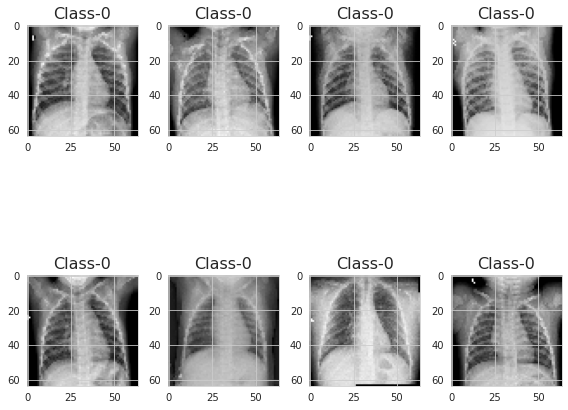

In [36]:
display_images(X_train_org, y_train, figure_row=2, figure_cols=4)

In [8]:
def preprocess_images(images, y, normalize = True):
    X = []
    for i in tqdm(range(len(images))):
        img = img_to_array(images[i]).astype('float32')
        if normalize:
            img = img/255.0
        X.append(img)
    #Shuffle data
    dataset = list(zip(X, y))
    random.shuffle(dataset)

    X, y = zip(*dataset)
    return np.array(X), np.array(y)

In [9]:
normalize = True

x_train, y_train =preprocess_images(X_train_org, y_train, normalize=normalize)
print("Shape of X_train:", x_train.shape)

x_val, y_val =preprocess_images(X_val_org, y_val, normalize=normalize)
print("Shape of X_val:", x_val.shape)

x_test, y_test =preprocess_images(X_test_org, y_test, normalize=normalize)
print("Shape of X_test:", x_test.shape)

anomaly, y_anomaly =preprocess_images(anomaly_org, y_anomaly, normalize=normalize)
print("Shape of anomaly:", anomaly.shape)

100%|██████████| 1341/1341 [00:00<00:00, 16135.87it/s]


Shape of X_train: (1341, 64, 64, 3)


100%|██████████| 8/8 [00:00<00:00, 15377.83it/s]


Shape of X_val: (8, 64, 64, 3)


100%|██████████| 234/234 [00:00<00:00, 23679.48it/s]


Shape of X_test: (234, 64, 64, 3)


100%|██████████| 390/390 [00:00<00:00, 24297.11it/s]

Shape of anomaly: (390, 64, 64, 3)


In [10]:
np.unique(y_train), np.unique(y_anomaly)

(array([0]), array([1]))

In [11]:
np.max(x_train), np.max(x_val), np.max(x_test), np.max(anomaly) 

(1.0, 1.0, 1.0, 1.0)

In [12]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, anomaly.shape, y_anomaly.shape 

((1341, 64, 64, 3),
 (1341,),
 (8, 64, 64, 3),
 (8,),
 (234, 64, 64, 3),
 (234,),
 (390, 64, 64, 3),
 (390,))

In [13]:
# Create the Encoder and Decoder
inputs = tf.keras.Input(shape=(64, 64, 3), name='input_layer')
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# output
outputs = tf.keras.layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

2022-08-21 14:47:52.078891: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-21 14:47:52.078943: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iotg): /proc/driver/nvidia/version does not exist
2022-08-21 14:47:52.079533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [15]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)

In [55]:
# Clear previous logs
# !rm -rf "../../logs"
# from keras.callbacks import TensorBoard

In [56]:
# !mkdir "../../logs"
# !ls "../../logs"

In [16]:
hist=autoencoder.fit(x_train, x_train,
                epochs=15,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val),
                #callbacks=[TensorBoard(log_dir="../../logs")]
                )

Epoch 1/15
11/11 [==============================] - 10s 832ms/step - loss: 0.6977 - val_loss: 0.7643
Epoch 2/15
11/11 [==============================] - 9s 785ms/step - loss: 0.3487 - val_loss: 0.7375
Epoch 3/15
11/11 [==============================] - 8s 764ms/step - loss: 0.2402 - val_loss: 0.7250
Epoch 4/15
11/11 [==============================] - 8s 746ms/step - loss: 0.1847 - val_loss: 0.7232
Epoch 5/15
11/11 [==============================] - 8s 746ms/step - loss: 0.1524 - val_loss: 0.7205
Epoch 6/15
11/11 [==============================] - 9s 765ms/step - loss: 0.1317 - val_loss: 0.7159
Epoch 7/15
11/11 [==============================] - 9s 775ms/step - loss: 0.1175 - val_loss: 0.7102
Epoch 8/15
11/11 [==============================] - 9s 771ms/step - loss: 0.1066 - val_loss: 0.7010
Epoch 9/15
11/11 [==============================] - 8s 756ms/step - loss: 0.0977 - val_loss: 0.6902
Epoch 10/15
11/11 [==============================] - 8s 746ms/step - loss: 0.0900 - val_loss: 0.676

In [53]:
# %load_ext tensorboard
# %tensorboard --logdir="../../logs" #Specify the path in fit

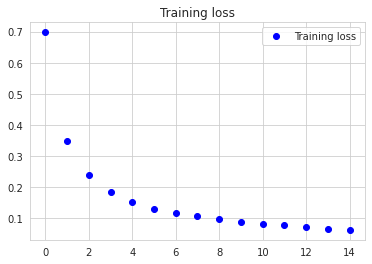

In [19]:

loss = hist.history['loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

8/8 [==============================] - 0s 20ms/step


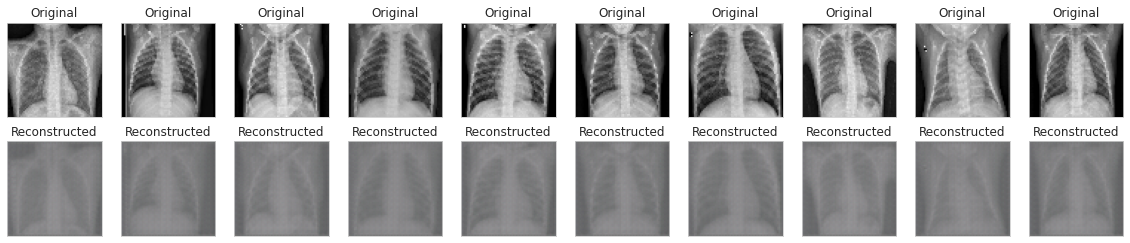

In [18]:
decoded_imgs = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [20]:
ssim_normal_errors = []
ssim_pneumonia_errors = []
predictions = autoencoder.predict(x_test)
predictions_anomaly = autoencoder.predict(anomaly)

13/13 [==============================] - 0s 17ms/step


In [21]:
len(predictions), predictions.shape, x_test.shape

(234, (234, 64, 64, 3), (234, 64, 64, 3))

In [22]:
len(predictions_anomaly), predictions_anomaly.shape, anomaly.shape

(390, (390, 64, 64, 3), (390, 64, 64, 3))

In [23]:
# Append ssim errors for the normal images 
for i in range(len(x_test)):
    value_a = SSIMLoss(predictions[i], x_test[i])
    ssim_normal_errors.append(value_a)

In [24]:
# Append ssim errors for the anomaly images 
for i in range(len(anomaly)):
    value_a = SSIMLoss(predictions_anomaly[i], anomaly[i])
    ssim_pneumonia_errors.append(value_a)

In [25]:
len(ssim_normal_errors), len(ssim_pneumonia_errors)

(234, 390)

In [41]:
for i in range(6):
    print("Normal error", ssim_normal_errors[i])
    print("Pneumonia error", ssim_pneumonia_errors[i])
    print("----------")

Normal error tf.Tensor(0.6417434, shape=(), dtype=float32)
Pneumonia error tf.Tensor(0.58223236, shape=(), dtype=float32)
----------
Normal error tf.Tensor(0.6355568, shape=(), dtype=float32)
Pneumonia error tf.Tensor(0.48464614, shape=(), dtype=float32)
----------
Normal error tf.Tensor(0.6425537, shape=(), dtype=float32)
Pneumonia error tf.Tensor(0.5062537, shape=(), dtype=float32)
----------
Normal error tf.Tensor(0.64920664, shape=(), dtype=float32)
Pneumonia error tf.Tensor(0.59814537, shape=(), dtype=float32)
----------
Normal error tf.Tensor(0.6086254, shape=(), dtype=float32)
Pneumonia error tf.Tensor(0.57338274, shape=(), dtype=float32)
----------
Normal error tf.Tensor(0.65395963, shape=(), dtype=float32)
Pneumonia error tf.Tensor(0.5278038, shape=(), dtype=float32)
----------


In [28]:
np.mean(ssim_normal_errors), np.mean(ssim_pneumonia_errors)

(0.63059586, 0.56670326)

In [29]:
# pneumonia = 1, normal = 0
# Determine the class of normal images based on the model threshold
# Granica zostaa ustalona na podstawie srednich wartosci bledow ssim
good = 0
index_good = []
bad = 0
index_bad = []
for i in range(len(x_test)):
    value_a = SSIMLoss(predictions[i], x_test[i])
    if(value_a > 0.6):
        if(y_test[i] == 0):
            good = good + 1
            index_good.append(i)
        else:
            bad = bad + 1
            index_bad.append(i)
    else:
        if(y_test[i] == 0):
            bad = bad + 1
            index_bad.append(i)
        else:
            good = good + 1
            index_good.append(i) 

In [42]:
print(good, bad)
print(len(index_good), len(index_bad))

191 43
191 43


In [31]:
# Determine the class of anomaly images based on the model threshold
pn_good = 0
pn_index_good = []
pn_bad = 0
pn_index_bad = []
for i in range(len(anomaly)):
    value_a = SSIMLoss(predictions_anomaly[i], anomaly[i])
    if(value_a < 0.6):
        if(y_anomaly[i] == 0):
            pn_bad = pn_bad + 1
            pn_index_bad.append(i)
        else:
            pn_good = pn_good + 1
            pn_index_good.append(i)
    else:
        if(y_anomaly[i] == 0):
            pn_good = pn_good + 1
            pn_index_good.append(i) 
        else:
            pn_bad = pn_bad + 1
            pn_index_bad.append(i)

In [32]:
# Accuracy 60%, 75%
print(pn_good, pn_bad)
print(len(pn_index_good), len(pn_index_bad))
#print(index_bad[2:17])

293 97
293 97


In [37]:
acc = (good + pn_good) / (bad + good + pn_good + pn_bad)
print("Accuracy of the model is ", acc)

Accuracy of the model is  0.7756410256410257


Found 184 incorrect labels


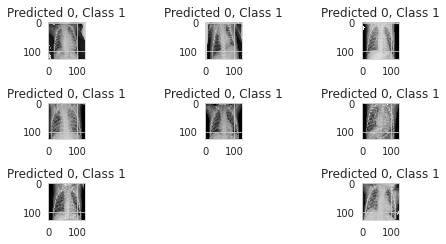

In [69]:
print("Found %d incorrect labels" % (pn_bad+bad))
for i, incorrect in enumerate(pn_index_bad[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(anomaly[incorrect], cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(0, y_anomaly[incorrect]))
    plt.tight_layout()

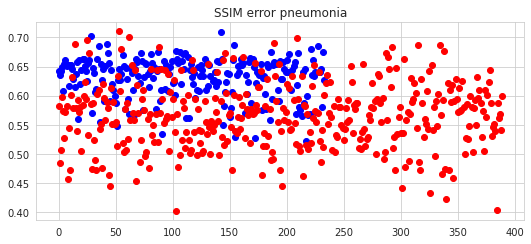

In [34]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.title("SSIM error pneumonia")
plt.plot(ssim_normal_errors, 'bo')
plt.plot(ssim_pneumonia_errors, 'ro')

plt.show()

In [83]:
!ls ../../

data  gradio  kn_venv  LICENSE	logs  models  notebooks  README.md


In [40]:
autoencoder.save("../../models/pneumonia_ae_acc77ssim06.h5")